## Q-learning (off-policy TD Control) Algorithm

Resources used while writing this notebook:
- [Nimish Sanghi's book on Deep RL](https://www.amazon.com/Deep-Reinforcement-Learning-Python-TensorFlow/dp/1484268083)
- [University of Alberta's RL specialization](https://www.coursera.org/specializations/reinforcement-learning)

![Q_learning](../algo_img/q_learning.png "Q_learning")

Update rule for Q-learning:

$$\displaystyle Q(S_t, A_t) \; = \; Q(S_t, A_t) \, + \, \alpha [R_{t+1} + \gamma \, max_{A_{t+1}} Q(S_{t+1}, A_{t+1}) \, - \, Q(S_t, A_t)]$$

- We generate samples using an exploratory policy (which is the behavior policy) like $\varepsilon$-greedy policy. 
- But, choose actions using an optimized policy (which is the target policy). 

In [13]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

In [14]:
class Q_Learning:
    """Q-learning (off-policy TD control) algorithm."""
    def __init__(self, get_possible_actions, strategy, 
                 epsilon=1, alpha=1, gamma=1):
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))
        self.get_possible_actions = get_possible_actions
        self.epsilon = epsilon
        self.strategy = strategy
        self.alpha = alpha   # learning rate or step size
        self.gamma = gamma   # discount factor


    def _get_Q(self, state, action):
        return self._Q[state][action]


    def set_Q(self, state, action, value):
        self._Q[state][action] = value


    def update(self, state, action, reward, next_state, done):
        """
        This is the main update function for the Q-learning algorithm.
        Note that this function only contains the update equations, 
        not the entire Q-learning algorithm.
        """
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = reward + \
                       self.gamma * self._get_Q(next_state, best_next_action) - \
                       self._get_Q(state, action)
        else:
            td_error = reward - self._get_Q(state, action)
        q_value = self._get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, q_value)


    def max_action(self, state):
        """
        Return the best action for a given state, ie,
        the action in the state-action pair that has the highest Q-value.
        If there are multiple actions with the same Q-value,
        return a random action from the set of best actions.
        """
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")
        for action in actions:
            q_value = self._get_Q(state, action)
            if q_value > best_q_value:
                best_action = [action]
                best_q_value = q_value
            elif q_value == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))


    def get_action(self, state):
        """
        Choose an action based on the input strategy.
        """
        return self.strategy(self.epsilon, self.get_possible_actions,
                             state, self.max_action)



In [15]:
def epsilon_greedy_strategy(epsilon, get_possible_actions, state, max_action):
    """
    Epsilon-greedy strategy.

    Choose a random number in the interval [0, 1) with a uniform 
    probability distribution. Use np.random.random() to do this.

    If this random number is less than epsilon, return a random action.
    Otherwise, return the best action for the given state.
    """
    actions = get_possible_actions(state)
    if len(actions) == 0:
        return None
    random_number = np.random.random()
    if random_number < epsilon:
        # exploration
        return np.random.choice(actions)
    else:
        # exploitation
        return max_action(state)
    

In [23]:
def train_agent(env, agent, num_episodes=10_000, t_max=10_000, decay_rate=None):
    """
    This is a generic training function.

    env: gymnasium environment
    agent: Q_Learning object
    num_episodes: (int) number of episodes to train the agent
    t_max: (int) maximum number of steps per episode
    decay_rate: (float) epsilon decay rate
    """
    episode_rewards = []
    for i in tqdm(range(num_episodes)):
        G = 0
        state, _ = env.reset()
        action = agent.get_action(state)
        for t in range(t_max):
            next_state, reward, done, trunc, _ = env.step(action)
            next_action = agent.get_action(next_state)
            flag = (done or trunc)
            agent.update(state, action, reward, next_state, flag)
            G += reward
            if flag:
                episode_rewards.append(G)
                if decay_rate is not None:
                    agent.epsilon = agent.epsilon * decay_rate
                break
            state = next_state
            action = next_action
    return np.array(episode_rewards)


In [24]:
def plot_rewards(env_name, rewards, label):
    plt.title(f"Env: {env_name}  Mean Reward: {np.mean(rewards[-20:]):.1f}")
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.show()


### Trying out Q-learning on Cliff Walking environment

In [25]:
Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif")

In [26]:
# create Cliff Walking environment
cw_env = gym.make("CliffWalking-v0")

In [27]:
cw_env.reset()

(36, {'prob': 1})

In [28]:
cw_env.action_space.n

4

In [29]:
cw_env.observation_space.n

48

In [30]:
agent1 = Q_Learning(
    get_possible_actions = lambda s : range(cw_env.action_space.n),
    strategy = epsilon_greedy_strategy,
    epsilon = 0.2,
    alpha = 0.25, 
    gamma = 0.99
)

rewards = train_agent(cw_env, agent1, num_episodes=5000, decay_rate=0.99)

100%|██████████| 5000/5000 [00:06<00:00, 820.34it/s]


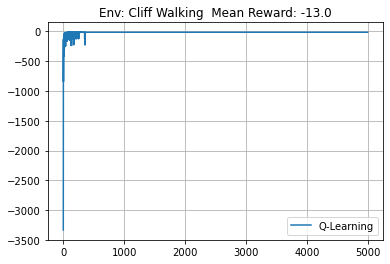

In [31]:
plot_rewards("Cliff Walking", rewards, "Q-Learning")

In [55]:
def fn():
    action_dict = {
        0: "UP",
        1: "RIGHT",
        2: "DOWN",
        3: "LEFT"
    }
    state, _ = cw_env.reset()
    print(f"state: {state}")
    while True:
        best_action = agent1.max_action(state)
        print(f"best_action: {action_dict[best_action]}")
        next_state, reward, done, trunc, _ = cw_env.step(best_action)
        if done or trunc:
            print(f"Terminal state reached.\nState: {next_state}")
            break
        state = next_state
        print(f"state: {state}")

fn()

state: 36
best_action: UP
state: 24
best_action: RIGHT
state: 25
best_action: RIGHT
state: 26
best_action: RIGHT
state: 27
best_action: RIGHT
state: 28
best_action: RIGHT
state: 29
best_action: RIGHT
state: 30
best_action: RIGHT
state: 31
best_action: RIGHT
state: 32
best_action: RIGHT
state: 33
best_action: RIGHT
state: 34
best_action: RIGHT
state: 35
best_action: DOWN
Terminal state reached.
State: 47


### Trying out Q-learning on Taxi environment

In [32]:
Image(url="https://gymnasium.farama.org/_images/taxi.gif")

In [34]:
t_env = gym.make("Taxi-v3")

In [35]:
t_env.reset()

(208, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [36]:
t_env.action_space.n

6

In [37]:
t_env.observation_space.n

500

In [39]:
agent2 = Q_Learning(
    get_possible_actions = lambda state: range(t_env.action_space.n),
    strategy = epsilon_greedy_strategy, 
    epsilon = 0.2,
    alpha = 0.25, 
    gamma = 0.99
)

rewards = train_agent(t_env, agent2, num_episodes=5000, decay_rate=0.99)

100%|██████████| 5000/5000 [00:10<00:00, 465.32it/s]


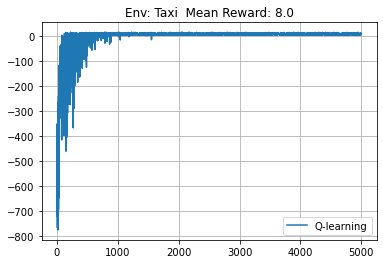

In [40]:
plot_rewards("Taxi", rewards, "Q-learning")

### Trying out Q-learning on BlackJack environment